# Load the libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the enhanced dataset

In [2]:
data = pd.read_pickle(r'C:\Users\Nandan Hegde\OneDrive\Documents\GitHub\MSU_STT810_Semester_projects\E-commerce_recommendation\Interim_Data\enhanced_1M_dataset.pkl')

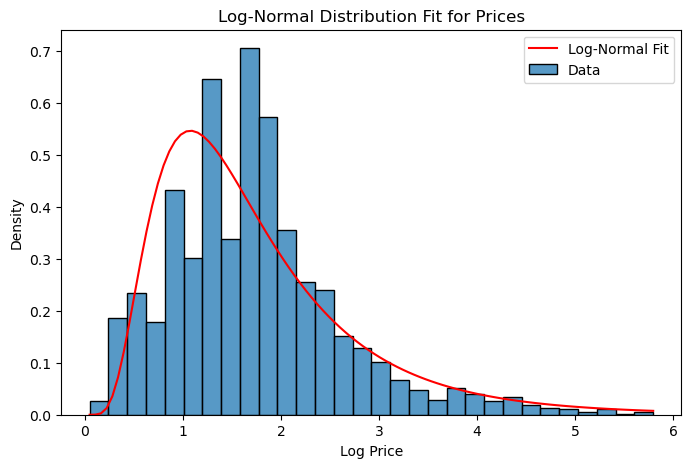

Log-normal fit parameters: shape=0.5742852996700768, loc=0, scale=1.4977777021675005


In [3]:
# Step 1: Extract log prices
log_prices = np.log(data['price'] + 1)

# Step 2: Fit a log-normal distribution
shape, loc, scale = stats.lognorm.fit(log_prices, floc=0)
x = np.linspace(log_prices.min(), log_prices.max(), 100)
pdf = stats.lognorm.pdf(x, shape, loc, scale)

# Step 3: Visualize the Fit
plt.figure(figsize=(8, 5))
sns.histplot(log_prices, bins=30, kde=False, stat='density', label='Data')
plt.plot(x, pdf, label='Log-Normal Fit', color='red')
plt.title("Log-Normal Distribution Fit for Prices")
plt.xlabel("Log Price")
plt.ylabel("Density")
plt.legend()
plt.show()

print(f"Log-normal fit parameters: shape={shape}, loc={loc}, scale={scale}")

In [4]:
# Kolmogorov-Smirnov test
ks_stat, ks_p_value = stats.kstest(log_prices, 'lognorm', args=(shape, loc, scale))
print(f"Kolmogorov-Smirnov Test Statistic: {ks_stat}")
print(f"P-value: {ks_p_value}")

Kolmogorov-Smirnov Test Statistic: 0.09584017328647398
P-value: 0.0


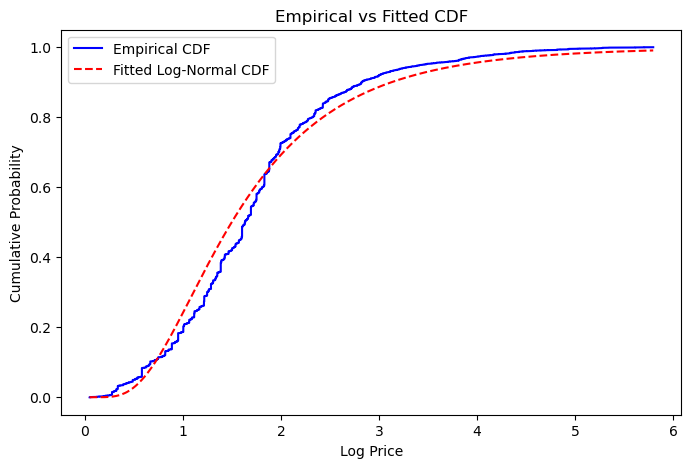

In [5]:
# Empirical CDF
empirical_cdf = np.arange(1, len(log_prices) + 1) / len(log_prices)
sorted_prices = np.sort(log_prices)

# Fitted CDF
fitted_cdf = stats.lognorm.cdf(sorted_prices, shape, loc, scale)

# Plot CDFs
plt.figure(figsize=(8, 5))
plt.plot(sorted_prices, empirical_cdf, label='Empirical CDF', color='blue')
plt.plot(sorted_prices, fitted_cdf, label='Fitted Log-Normal CDF', color='red', linestyle='--')
plt.title("Empirical vs Fitted CDF")
plt.xlabel("Log Price")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.show()

Purchases by Price Category:
price_category
High        309
Low       57494
Medium     1155
dtype: int64


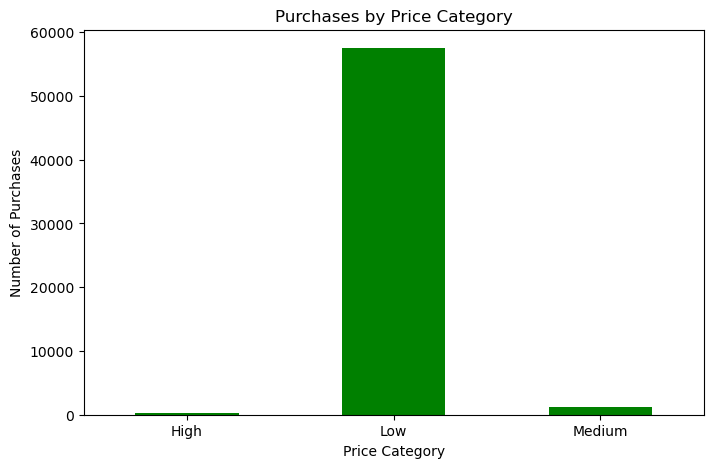

In [6]:
# Categorize products by price range
def categorize_price(price):
    if price < 20:
        return 'Low'
    elif 20 <= price <= 50:
        return 'Medium'
    else:
        return 'High'

data['price_category'] = data['price'].apply(categorize_price)

# Count purchases by price category
category_counts = data[data['event_type'] == 'purchase'].groupby('price_category').size()
print("Purchases by Price Category:")
print(category_counts)

# Bar plot
plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color='green')
plt.title("Purchases by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=0)
plt.show()

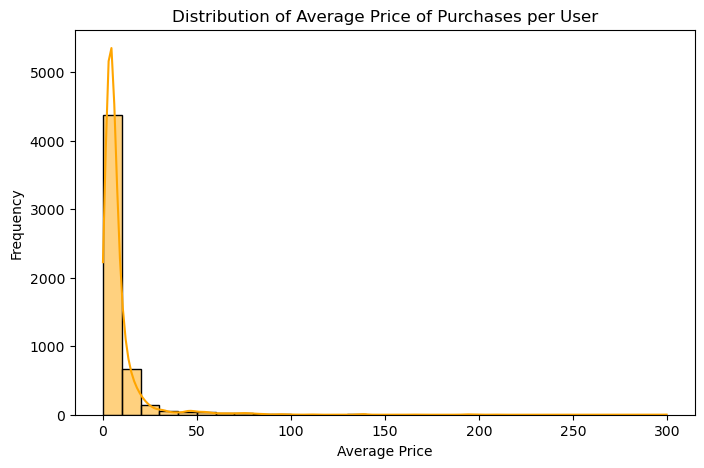

In [7]:
# Compute average price of purchases per user
user_avg_prices = data[data['event_type'] == 'purchase'].groupby('user_id')['price'].mean()

# Visualize distribution
plt.figure(figsize=(8, 5))
sns.histplot(user_avg_prices, bins=30, kde=True, color='orange')
plt.title("Distribution of Average Price of Purchases per User")
plt.xlabel("Average Price")
plt.ylabel("Frequency")
plt.show()

C:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^

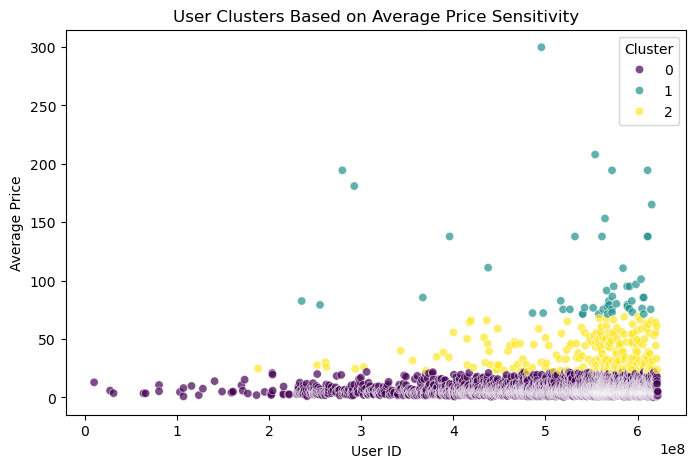

In [8]:
from sklearn.cluster import KMeans

# Prepare data for clustering
user_avg_prices = user_avg_prices.reset_index()
user_avg_prices.rename(columns={'price': 'avg_price'}, inplace=True)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
user_avg_prices['cluster'] = kmeans.fit_predict(user_avg_prices[['avg_price']])

# Visualize clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x='user_id', y='avg_price', hue='cluster', data=user_avg_prices, palette='viridis', alpha=0.7)
plt.title("User Clusters Based on Average Price Sensitivity")
plt.xlabel("User ID")
plt.ylabel("Average Price")
plt.legend(title="Cluster")
plt.show()

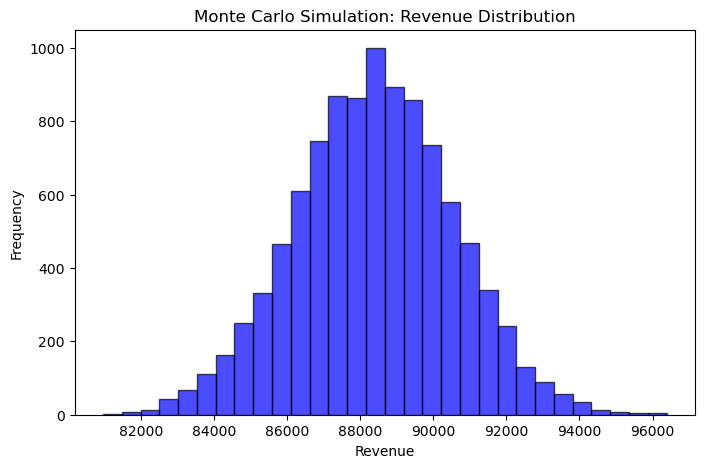

Expected Revenue: $88,378.16
Revenue Std Dev: $2,171.27
95% Confidence Interval: $84,044.83 - $92,620.82


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
avg_price = data['price'].mean()
std_dev_price = data['price'].std()
conversion_rate = 0.1  # Example: 10% of users convert to purchase
total_users = 100000  # Total active users

# Monte Carlo simulation
n_simulations = 10000
revenues = []

for _ in range(n_simulations):
    # Simulate prices
    simulated_prices = np.random.normal(avg_price, std_dev_price, total_users)
    
    # Simulate conversions
    purchases = np.random.binomial(1, conversion_rate, total_users)
    
    # Calculate revenue
    revenue = np.sum(simulated_prices * purchases)
    revenues.append(revenue)

# Plot results
plt.figure(figsize=(8, 5))
plt.hist(revenues, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Monte Carlo Simulation: Revenue Distribution")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.show()

# Summary statistics
print(f"Expected Revenue: ${np.mean(revenues):,.2f}")
print(f"Revenue Std Dev: ${np.std(revenues):,.2f}")
print(f"95% Confidence Interval: ${np.percentile(revenues, 2.5):,.2f} - ${np.percentile(revenues, 97.5):,.2f}")